In [88]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import random 
from tqdm import tqdm_notebook as tqdm

from ic_influence_maximization.generate_graph import generate_graph
from ic_influence_maximization.utils import pp, miia, mip, mioa, in_neighbors
from ic_influence_maximization.greedy_ic import naive_greedy_algorithm, ap
from ic_influence_maximization.pmia import pmia
from ic_influence_maximization.degreeHeuristic import degreeHeuristic

import time

theta =  0.003

## Time of execution with different number of nodes and constant number of seed nodes : 

In [5]:
time_pmia=[]
time_maxdegree=[]
for i in range(10,200,20):
    graph = generate_graph(num_nodes_min_max=[i, i+5], directed=True, rate=0.6)
    start_time_pmia = time.time()
    path_pmia = pmia(graph, 5, theta, tqdm_function=tqdm)
    end_time_pmia = time.time()
    start_time_maxdegree =time.time()
    path_maxdegree=degreeHeuristic(graph, 5)
    end_time_maxdegree = time.time()
    time_pmia.append((start_time_pmia-end_time_pmia))
    time_maxdegree.append((start_time_maxdegree-end_time_maxdegree))

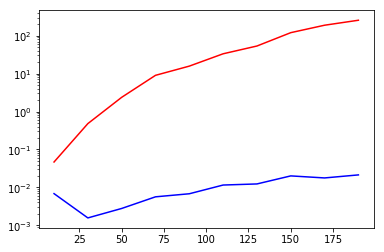

In [9]:
n=range(10,200,20)
plt.semilogy(n,-np.array(time_pmia),'r')
plt.plot(n,-np.array(time_maxdegree),'b')
plt.show()

## Time of execution with constant number of nodes and different number of seed nodes : 

In [40]:
time_pmia_seeds=[]
time_maxdegree_seeds=[]
for i in range(1,10):
    graph = generate_graph(num_nodes_min_max=[10, 25], directed=True, rate=0.6) 
    start_time_pmia = time.time()
    path_pmia = pmia(graph, i, theta, tqdm_function=tqdm)
    end_time_pmia = time.time()
    start_time_maxdegree =time.time()
    path_maxdegree=degreeHeuristic(graph, i)
    end_time_maxdegree = time.time()
    time_pmia_seeds.append((start_time_pmia-end_time_pmia))
    time_maxdegree_seeds.append((start_time_maxdegree-end_time_maxdegree))

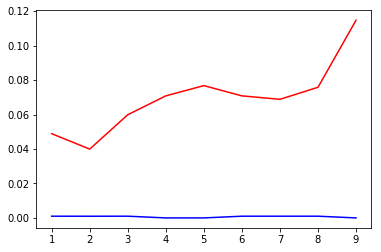

In [60]:
n=range(1,10)
plt.plot(n,-np.array(time_pmia_seeds),'r',label='pmia')
plt.plot(n,-np.array(time_maxdegree_seeds),'b',label='maxdegree')
plt.show()

## Comparison of Influence spread : 

In [112]:

graph = generate_graph(num_nodes_min_max=[70, 71], directed=True, rate=0.3) 


def compute_influence(graph_base, path):
    graph = graph_base.copy()
    total_influence = 0
    for node in path:
        graph.nodes[node]['on'] = True

    new_influence = len(path)
    while new_influence > total_influence:
        total_influence = new_influence
        for node in graph.nodes:
            if graph.nodes[node].get('on', False):
                for edge in graph.edges(node):
                    if graph.edges[edge]['on'] and not graph.nodes[edge[1]].get('on', False):
                        graph.nodes[edge[1]]['on'] = True
                        new_influence += 1
                        
    return new_influence

In [113]:
pmia_inf = []
max_deg_inf = []
for i in tqdm(range(1, 20, 3)):
    path_pmia = pmia(graph, i, theta, tqdm_function=tqdm)
    path_maxdegree=degreeHeuristic(graph, i)
    
    pmia_inf_i = []
    max_deg_inf_i = []
    for _ in range(50):
        for edge in graph.edges:
            graph.edges[edge]['on'] = random.random() < graph.edges[edge]['transition_proba']
        
        pmia_inf_i.append(compute_influence(graph, path_pmia))
        max_deg_inf_i.append(compute_influence(graph, path_maxdegree))
    
    pmia_inf.append(np.mean(pmia_inf_i))
    max_deg_inf.append(np.mean(max_deg_inf_i))

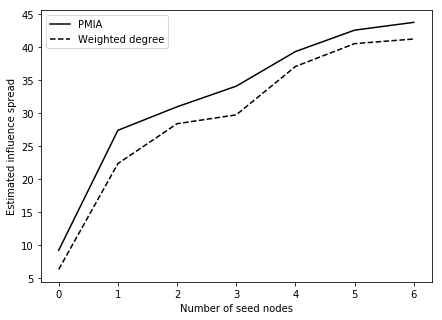

In [117]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(pmia_inf,  'k-', label="PMIA")
plt.plot(max_deg_inf, 'k--', label="Weighted degree")
plt.xlabel("Number of seed nodes")
plt.ylabel("Estimated influence spread")
plt.legend()

In [120]:
pmia_inf = []
max_deg_inf = []
random_inf = []
for i in tqdm(range(10, 130, 3)):
    graph = generate_graph(num_nodes_min_max=[i, i+1], directed=True, rate=0.3) 
    path_pmia = pmia(graph, 1, theta, tqdm_function=tqdm)
    path_maxdegree = degreeHeuristic(graph, 1)
    random_deg = np.random.choice(graph.nodes, size=1)
    
    pmia_inf_i = []
    max_deg_inf_i = []
    random_inf_i = []
    for _ in range(50):
        for edge in graph.edges:
            graph.edges[edge]['on'] = random.random() < graph.edges[edge]['transition_proba']
        
        pmia_inf_i.append(compute_influence(graph, path_pmia))
        max_deg_inf_i.append(compute_influence(graph, path_maxdegree))
        random_inf_i.append(compute_influence(graph, random_deg))
    
    pmia_inf.append(np.mean(pmia_inf_i))
    max_deg_inf.append(np.mean(max_deg_inf_i))
    random_inf.append(np.mean(random_inf_i))

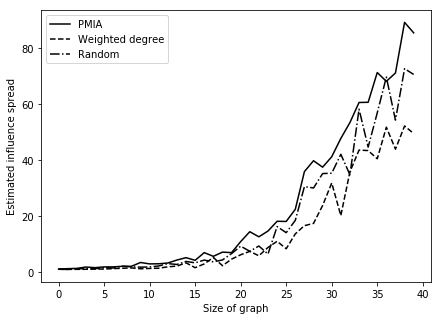

In [122]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(pmia_inf,  'k-', label="PMIA")
plt.plot(max_deg_inf, 'k--', label="Weighted degree")
plt.plot(random_inf, 'k-.', label="Random")
plt.xlabel("Size of graph")
plt.ylabel("Estimated influence spread")
plt.legend()